In [1]:
import uproot4
#import coffea
%pylab inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import awkward1 as ak
#from coffea import hist, processor
#from coffea.analysis_objects import JaggedCandidateArray
#from coffea.nanoaod import NanoEvents

from dask.distributed import Client, progress
import distributed

from condor_utils import make_htcondor_cluster
import utils

import mplhep
plt.style.use(mplhep.style.CMS)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#from coffea.nanoevents.methods import candidate
##from NanoEvents.methods import candidate
#ak.behavior.update(candidate.behavior)

In [2]:
from utils import get_results, clear_tree_cache, plot_timeflow

In [3]:
client = Client("tcp://169.228.130.5:29743")
client

Client Scheduler: tcp://169.228.130.5:29743 Dashboard: http://169.228.130.5:13346/status,Cluster Workers: 50 Cores: 50 Memory: 300.00 GB


In [46]:
%%time

DY_files = "/hadoop/cms/store/user/hmei/nanoaod_runII/HHggtautau//DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8_RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1_MINIAODSIM_v0.6_20201021/*.root"
ttbar_files = "/hadoop/cms/store/user/legianni/ProjectMetis/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8_18____x3/*root"

import glob
background_fileset = {
    #"DYJets": [glob.glob(DY_files)[0]]
    "DYJets": glob.glob(DY_files),
    "ttbar": glob.glob(ttbar_files)
}

signal_fileset = {
    "signal":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/HHggtautau_Era2018_private_prova_vera/*.root"),
}

data_fileset = {
    "EGamma_2018A":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/EGamma_Run2018A____x3/*root"),
    "EGamma_2018B":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/EGamma_Run2018B____x3/*root"),
    "EGamma_2018C":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/EGamma_Run2018C____x3/*root"),
    "EGamma_2018D":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/EGamma_Run2018D____x3/*root")
}

filesets = {"data": data_fileset, "background": background_fileset, "signal": signal_fileset}

CPU times: user 7.89 ms, sys: 2.06 ms, total: 9.96 ms
Wall time: 341 ms


## this part only needs to do it once, could write to file in case need to restart notebook

In [47]:
%%time

chunk_size = 5e5
chunks = {}
tot_evts = 0

for cat in ["data", "background", "signal"]:
    fileset = filesets[cat]
    for key in fileset:
        fnames = fileset[key]
        cks, evts = utils.get_chunking(tuple(fnames),chunk_size,treename="Events")
        chunks[key] = cks
        tot_evts += evts
        print("{}: total {} events, got {} files, return {} chunks".format(key, evts, len(fnames), len(cks))) 
print()
#print(chunks.keys())
print ("total events to be processed: {0:8.2e}".format(tot_evts) )

EGamma_2018A: total 93164815 events, got 239 files, return 239 chunks
EGamma_2018B: total 50705031 events, got 98 files, return 155 chunks
EGamma_2018C: total 49484413 events, got 110 files, return 118 chunks
EGamma_2018D: total 229268651 events, got 426 files, return 782 chunks
DYJets: total 997561 events, got 15 files, return 15 chunks
ttbar: total 35821609 events, got 167 files, return 167 chunks
signal: total 712801 events, got 50 files, return 50 chunks

total events to be processed: 4.60e+08
CPU times: user 9.77 s, sys: 2.39 s, total: 12.2 s
Wall time: 1min 23s


## scratch area

In [6]:
# example of chunk
chunks["EGamma_2018D"][0],chunks["EGamma_2018D"][1]

(('/hadoop/cms/store/user/legianni/ProjectMetis/EGamma_Run2018D____x3/test_nanoaodSkim_1.root',
  0,
  500000),
 ('/hadoop/cms/store/user/legianni/ProjectMetis/EGamma_Run2018D____x3/test_nanoaodSkim_1.root',
  500000,
  517981))

In [7]:
f_test = uproot4.open(chunks["EGamma_2018D"][0][0])
t_test = f_test["Events"]
electron_keys = t_test.keys(filter_name="Electron_*")
electron_keys

['Electron_deltaEtaSC',
 'Electron_dr03EcalRecHitSumEt',
 'Electron_dr03HcalDepth1TowerSumEt',
 'Electron_dr03TkSumPt',
 'Electron_dr03TkSumPtHEEP',
 'Electron_dxy',
 'Electron_dxyErr',
 'Electron_dz',
 'Electron_dzErr',
 'Electron_eCorr',
 'Electron_eInvMinusPInv',
 'Electron_energyErr',
 'Electron_eta',
 'Electron_hoe',
 'Electron_ip3d',
 'Electron_jetPtRelv2',
 'Electron_jetRelIso',
 'Electron_mass',
 'Electron_miniPFRelIso_all',
 'Electron_miniPFRelIso_chg',
 'Electron_mvaFall17V1Iso',
 'Electron_mvaFall17V1noIso',
 'Electron_mvaFall17V2Iso',
 'Electron_mvaFall17V2noIso',
 'Electron_pfRelIso03_all',
 'Electron_pfRelIso03_chg',
 'Electron_phi',
 'Electron_pt',
 'Electron_r9',
 'Electron_scEtOverPt',
 'Electron_sieie',
 'Electron_sip3d',
 'Electron_mvaTTH',
 'Electron_charge',
 'Electron_cutBased',
 'Electron_cutBased_Fall17_V1',
 'Electron_jetIdx',
 'Electron_pdgId',
 'Electron_photonIdx',
 'Electron_tightCharge',
 'Electron_vidNestedWPBitmap',
 'Electron_vidNestedWPBitmapHEEP',
 'E

## actual processing of data

In [48]:
## need to use dask to do this...

def get_totWeight(files):
    sumWeight = 0
    for file in files:
        f = uproot4.open(file[0])
        t = f["Events"]
        #print (t) 
        genWeight = t.arrays("genWeight",entry_start=file[1],entry_stop=file[2])#,library="ak")
        tot_w = ak.sum(genWeight)
        sumWeight += tot_w
    return sumWeight

#get_totWeight(chunks["DYJets"])
get_totWeight(chunks["ttbar"])

70894446784.0

In [9]:
sumw_ttbar = 70894446784.0
sumw_dy = 17799596672.0

In [10]:
%%time

from yahist import Hist1D
import uproot_methods

def process_electron(args):
    fname,entrystart,entrystop = args
    
    f = uproot4.open(fname)
    t = f["Events"]
    
    electron_keys = t.keys(filter_name="Electron_*") 
    electrons = t.arrays( electron_keys, entry_start=entrystart, entry_stop=entrystop, library="ak", how="zip")
    
    genWeight = np.array(ones(len(electrons))) 
    if not ("EGamma" in fname):
        genWeight = t.arrays( "genWeight", entry_start=entrystart, entry_stop=entrystop)#, library="ak", how="zip")
        
    #print (genWeight)
    # filter electron
    cut_ele_pt = electrons.Electron.pt > 25
    cut_ele_eta = abs(electrons.Electron.eta) < 2.5
    cut_ele_dxy = abs(electrons.Electron.dxy) < 0.045
    cut_ele_dz = abs(electrons.Electron.dz) < 0.2
    cut_ele_id = electrons.Electron.mvaFall17V2Iso_WP80 == True
    
    # build mask
    mask_ele = cut_ele_pt & cut_ele_eta & cut_ele_dxy & cut_ele_dz #& cut_ele_id
    electrons_selected = electrons[mask_ele]
   
    # make di-ele opposite sign
    mask_diele_os = ( ak.num(electrons_selected.Electron) == 2 ) & ( ak.sum(electrons_selected.Electron.charge, axis=1) == 0)
    electrons_fromdiele = electrons_selected[mask_diele_os]
    genWeight_fromdiele = genWeight[mask_diele_os]
    
    ele0 = electrons_fromdiele.Electron[:,0]
    ele1 = electrons_fromdiele.Electron[:,1]
    
    diele_mass = np.sqrt(2*ele0.pt*ele1.pt*(np.cosh(ele0.eta - ele1.eta) - np.cos(ele0.phi - ele1.phi)))
    
    mask_hist = (diele_mass > 60) & (diele_mass < 120)
    
    weight_hist = genWeight_fromdiele[mask_hist]
    if not ("EGamma" in fname):
        weight_hist = genWeight_fromdiele.genWeight[mask_hist]
        
    return Hist1D(ak.to_numpy(diele_mass[mask_hist]), bins=np.linspace(60,120,61),
                  weights=ak.to_numpy(weight_hist) )

hist0 = process_electron( chunks["EGamma_2018D"][0] )
#hist0 = process_electron( chunks["DYJets"][0] )
#hist1 = process_electron( chunks["EGamma_2018D"][1] )

hist0 #+ hist1

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.228.130.5:4486 remote=tcp://169.228.130.5:29743>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.228.130.5:4532 remote=tcp://169.228.130.5:29743>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://169.228.130.5:4618 remote=tcp://169.228.130.5:29743>


CPU times: user 12.1 s, sys: 633 ms, total: 12.8 s
Wall time: 18.1 s


[126.00 ± 11.22   126.00 ± 11.22   127.00 ± 11.27   138.00 ± 11.75
 159.00 ± 12.61   148.00 ± 12.17   157.00 ± 12.53   178.00 ± 13.34
 184.00 ± 13.56   188.00 ± 13.71   218.00 ± 14.76   220.00 ± 14.83
 264.00 ± 16.25   246.00 ± 15.68   258.00 ± 16.06   295.00 ± 17.18
 319.00 ± 17.86   376.00 ± 19.39   424.00 ± 20.59   454.00 ± 21.31
 571.00 ± 23.90   675.00 ± 25.98   835.00 ± 28.90   1004.00 ± 31.69
 1316.00 ± 36.28   1687.00 ± 41.07   2251.00 ± 47.44   3037.00 ± 55.11
 3713.00 ± 60.93   4682.00 ± 68.43   4738.00 ± 68.83   4227.00 ± 65.02
 3289.00 ± 57.35   2320.00 ± 48.17   1681.00 ± 41.00   1225.00 ± 35.00
 860.00 ± 29.33   639.00 ± 25.28   506.00 ± 22.49   393.00 ± 19.82
 399.00 ± 19.97   346.00 ± 18.60   271.00 ± 16.46   291.00 ± 17.06
 257.00 ± 16.03   237.00 ± 15.39   206.00 ± 14.35   207.00 ± 14.39
 192.00 ± 13.86   197.00 ± 14.04   182.00 ± 13.49   190.00 ± 13.78
 163.00 ± 12.77   169.00 ± 13.00   157.00 ± 12.53   129.00 ± 11.36
 177.00 ± 13.30   159.00 ± 12.61   129.00 ± 11.36   149.00 ± 12.21]

## send to dask

In [49]:
for key in chunks:
    print (key)

EGamma_2018A
EGamma_2018B
EGamma_2018C
EGamma_2018D
DYJets
ttbar
signal


In [50]:
%%time
from dask.distributed import as_completed

futures = {}
results = {}

for key in chunks:
    print ("start process {}".format(key))
    futures[key] = client.map(process_electron, chunks[key])
    
    results_local = []
    #if key != "ttbar": continue
    while len(results_local) < len(chunks[key]): 
        ac = as_completed(futures[key], with_results=True)
        
        for future, result in ac:
            results_local.append(result)
            
    results[key] = np.sum(np.array(results_local))
    
#from datetime import datetime
#
#now = datetime.now()
#
#current_time = now.strftime("%H:%M:%S")
#print("Current Time =", current_time)

start process EGamma_2018A
start process EGamma_2018B
start process EGamma_2018C
start process EGamma_2018D
start process DYJets
start process ttbar
start process signal
CPU times: user 2.28 s, sys: 215 ms, total: 2.49 s
Wall time: 7min 32s


In [34]:
mee_data = results["EGamma_2018A"] + results["EGamma_2018B"] + results["EGamma_2018C"] + results["EGamma_2018D"]
mee_dy = results["DYJets"]
mee_ttbar = results["ttbar"]

In [52]:
# save scale1fb in the beginning...

mee_dy_weighted = mee_dy / sumw_dy * 59.0 * 1000 * 5941.0
mee_ttbar_weighted = mee_ttbar / sumw_dy * 59.0 * 1000 * 831.76
mee_ttbar_weighted

[115212.97 ± 2204.17   118051.06 ± 2240.16   118385.81 ± 2252.30
 123935.62 ± 2246.50   123280.12 ± 2259.59   121405.23 ± 2274.20
 123442.69 ± 2270.18   123234.20 ± 2288.93   124209.35 ± 2286.06
 126493.16 ± 2273.88   124744.75 ± 2274.90   123565.92 ± 2279.29
 119919.55 ± 2270.12   120059.62 ± 2268.26   124485.67 ± 2260.50
 121270.34 ± 2247.10   114985.87 ± 2227.22   119841.74 ± 2223.73
 115151.13 ± 2205.77   117253.06 ± 2206.88   110956.86 ± 2181.65
 114163.95 ± 2175.77   113197.66 ± 2167.80   109960.36 ± 2163.12
 110914.61 ± 2130.46   107799.99 ± 2112.62   107125.43 ± 2113.37
 105568.82 ± 2092.69   105574.00 ± 2080.31   100126.42 ± 2051.25
 97845.35 ± 2051.96   100157.10 ± 2030.24   96192.62 ± 2016.29
 97211.41 ± 2004.23   94331.31 ± 1988.53   92750.11 ± 1973.82
 88980.48 ± 1948.18   90980.94 ± 1930.68   88565.46 ± 1920.35
 86074.28 ± 1900.51   85561.30 ± 1891.40   82334.25 ± 1854.31
 84384.92 ± 1844.02   79553.02 ± 1838.82   78054.39 ± 1819.35
 77690.62 ± 1807.80   75630.95 ± 1794.71   75904.68 ± 1781.15
 75035.74 ± 1775.74   75086.24 ± 1760.85   72046.24 ± 1736.61
 70615.04 ± 1723.77   70585.44 ± 1706.70   70159.58 ± 1686.67
 65564.65 ± 1685.90   69294.00 ± 1676.15   66479.52 ± 1644.95
 64021.92 ± 1642.06   64756.89 ± 1626.84   59483.55 ± 1608.18]

In [73]:
mee_ttbar_weighted._metadata["label"] = "ttbar"
mee_dy_weighted._metadata["label"] = "DY"

(0.5, 1.5)

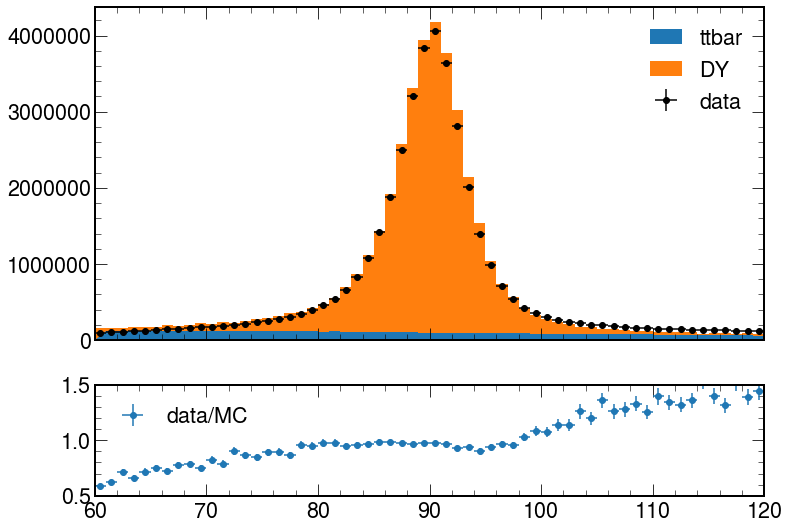

In [74]:
from yahist.utils import plot_stack

fig,(ax1,ax2) = plt.subplots(2,sharex=True,figsize=(12,9),gridspec_kw=dict(height_ratios=[3, 1]))
#mee_data.normalize().plot(ax=ax1,histtype="step", label="data", show_errors=True)
#mee_dy.normalize().plot(ax=ax1,alpha=0.8,color="C3", label="mc")
#(mee_data.normalize()/mee_dy.normalize()).plot(ax=ax2,show_errors=True,label="data/MC")

mee_data.plot(ax=ax1,histtype="step", label="data", show_errors=True, color="black")
plot_stack([mee_ttbar_weighted, mee_dy_weighted],ax=ax1)

mee_mc = mee_dy_weighted + mee_ttbar_weighted

#mee_dy_weighted.plot(ax=ax1,alpha=0.8,color="C3", label="DY")
(mee_data/mee_mc).plot(ax=ax2,show_errors=True,label="data/MC")
ax2.set_ylim(0.5,1.5)